In [30]:
#Set up environment and import necessary dependencies

%matplotlib inline
from __future__ import division;
from __future__ import print_function;
from __future__ import absolute_import;
import sys, os;
from collections import OrderedDict, namedtuple;
import numpy as np;

#Import some general util stuff
scriptsDir = os.environ.get("UTIL_SCRIPTS_DIR");
if (scriptsDir is None):
    raise Exception("Please set environment variable UTIL_SCRIPTS_DIR to point to av_scripts");
sys.path.insert(0,scriptsDir);
import pathSetter;
import util;
import fileProcessing as fp
from plottingUtilitiesPackage import matplotlibHelpers as mplh;

#import deepLIFT stuff
scriptsDir = os.environ.get("ENHANCER_SCRIPTS_DIR");
if (scriptsDir is None):
    raise Exception("Please set environment variable ENHANCER_SCRIPTS_DIR to point to enhancer_prediction_code");
sys.path.insert(0,scriptsDir+"/featureSelector/deepLIFFT/");
import criticalSubsetIdentification as csi
import deepLIFTutils
sys.path.insert(0,scriptsDir+"/featureSelector/deepLIFFT/kerasBasedBackprop");
from deepLIFTonGPU import ScoreTypes, Activations_enum, OutLayerInfo, getScoreFunc

#Make sure the directory is set to import the lab's version of keras
scriptsDir = os.environ.get("KERAS_DIR");
if (scriptsDir is None):
    raise Exception("Please set environment variable KERAS_DIR");
sys.path.insert(0,scriptsDir)

In [2]:
#load the data
from importDataPackage import importData
reload(importData)
#yamlDir="/srv/scratch/annashch/deeplearning/heterokaryon/yaml"
yamlDir="/srv/scratch/annashch/deeplearning/heterokaryon/yaml_sliding_pangwei_allpairs"
trainData, validData, testData = importData.loadTrainTestValidFromYaml(
                                    yamlDir+"/features.yaml"
                                    ,yamlDir+"/labels.yaml"
                                    ,yamlDir+"/splits.yaml")
del trainData
del validData #to save memory 

Processed 5000 lines of inputs/heterokaryon.sliding.pangwei.1.fasta
Processed 10000 lines of inputs/heterokaryon.sliding.pangwei.1.fasta
Processed 15000 lines of inputs/heterokaryon.sliding.pangwei.1.fasta
Processed 20000 lines of inputs/heterokaryon.sliding.pangwei.1.fasta
Processed 25000 lines of inputs/heterokaryon.sliding.pangwei.1.fasta
Processed 30000 lines of inputs/heterokaryon.sliding.pangwei.1.fasta
Processed 35000 lines of inputs/heterokaryon.sliding.pangwei.1.fasta
Processed 40000 lines of inputs/heterokaryon.sliding.pangwei.1.fasta
Processed 45000 lines of inputs/heterokaryon.sliding.pangwei.1.fasta
Processed 50000 lines of inputs/heterokaryon.sliding.pangwei.1.fasta
Processed 55000 lines of inputs/heterokaryon.sliding.pangwei.1.fasta
Processed 60000 lines of inputs/heterokaryon.sliding.pangwei.1.fasta
Processed 65000 lines of inputs/heterokaryon.sliding.pangwei.1.fasta
Processed 70000 lines of inputs/heterokaryon.sliding.pangwei.1.fasta
Processed 75000 lines of inputs/het

In [3]:
modelsDir="/srv/scratch/annashch/deeplearning/heterokaryon/modelsDir_runsDbPeytonModel_AllPairs"
modelWeights=modelsDir+"/bestModel_record_1_model_pZ9RQ_modelWeights.h5" 
modelYaml=modelsDir+"/bestModel_record_1_model_pZ9RQ_modelYaml.yaml" 

model = deepLIFTutils.loadKerasModel(modelWeights, modelYaml)
reload(deepLIFTutils);
deepLIFTutils.meanNormaliseFirstConvLayerWeights(model);

In [4]:
data=testData

In [5]:
model.layers

In [6]:
import deepLIFTutils
reload(deepLIFTutils)
from importDataPackage import importData
reload(importData)

#compile the validationData and testData into one set
#data = importData.InputData.concat(validData, testData)
data=testData 
#Get all the outputs on the data set:
outputs = deepLIFTutils.getSequentialModelLayerOutputs(
                                        model
                                        , inputDatas=[data.X]
                                        , layerIdx=-1
                                        , batchSize=10)


('Done', 0)
('Done', 10000)
('Done', 20000)
('Done', 30000)
('Done', 40000)
('Done', 50000)
('Done', 60000)
('Done', 70000)
('Done', 80000)


In [7]:
#Get the specific outputs for the neuron of interest ((1) and (2) from before)
neuronOfInterest_idx = 4 #first 4 tasks have a lot more true pos! 
outputs_singleNeuron = [x[neuronOfInterest_idx] for x in outputs];
trueLabels_singleNeuron = [x[neuronOfInterest_idx] for x in data.Y]

In [8]:
#If you set thresholdProb below to something other than 0.5, you
#would also be filtering for true positives whose predicted prob
#was greater than that threshold.
truePositiveIndices=csi.getTruePositiveIndicesAboveThreshold(
                            outputs=outputs_singleNeuron
                            , trueLabels=trueLabels_singleNeuron
                            , thresholdProb=0.5)

Deprecated; use deepLIFTutils.getTruePositiveIndicesAboveThreshold
CHECK THAT THIS LOOKS RIGHT!!
Proportion in various quadrants of confusion mat:
(first index is 'true label', second index is 'predicted')
(0, 0, 0.8649144015910775)
(0, 1, 0.1350855984089225)
(1, 0, 0.6896952104499274)
(1, 1, 0.31030478955007257)
('After filtering for true predictions with prob above', 0.5, 'there are', 1069, 'down from', 1069, '(total pos:', 3445, 'of', 80374, ')')


In [9]:
#Compile the deepLIFT scoring function.
#'0' is specially interpreted to indicate the raw input layer - in this case the sequence. That's
#what we want to track. You can specify other layers - eg model.layers[0] will track the output
#of the first convooutputLayerIdx = 0; #idx of the output layer in outputLayers argument to compiling the scoreFunc abovelutional layer (before the nonlinearity is applied)
trackLayers = [0]
outputLayers = [OutLayerInfo(outLayNoAct=model.layers[-2],activation='sigmoid')]
import deepLIFTonGPU
reload(deepLIFTonGPU)
scoreFunc = deepLIFTonGPU.getScoreFunc(model, trackLayers, outputLayers, 
                          [ScoreTypes.deepLIFT_rawContrib, ScoreTypes.sensitivity]);

In [10]:
#Run the scoring function on the full valid+test set
reload(deepLIFTutils)
#subset to just the true positives 
#figure out what the true positives are
labelsForNeuronOfInterest = [x[neuronOfInterest_idx] for x in data.Y]
outputsForNeuronOfInterest = [x[neuronOfInterest_idx] for x in outputs]
threshold=0.5
truePositiveIndices = csi.getTruePositiveIndicesAboveThreshold(
                                outputs=outputsForNeuronOfInterest
                                , trueLabels=labelsForNeuronOfInterest
                                , thresholdProb=threshold
                                , classifProb=threshold)
#Getting highly ranked true positives 
data_x_tp=data.X[truePositiveIndices]
data_y_tp=data.Y[truePositiveIndices]

#allDLOutputOnData = deepLIFTutils.runScoreFuncOnData(batchSize=10
#                                                          , data=data.X
#                                                          , scoreFunc=scoreFunc
#                                                          , progressUpdate=50)
allDLOutputOnData = deepLIFTutils.runScoreFuncOnData(batchSize=10
                                                          , data=data_x_tp
                                                          , scoreFunc=scoreFunc
                                                          , progressUpdate=50)

Deprecated; use deepLIFTutils.getTruePositiveIndicesAboveThreshold
CHECK THAT THIS LOOKS RIGHT!!
Proportion in various quadrants of confusion mat:
(first index is 'true label', second index is 'predicted')
(0, 0, 0.8649144015910775)
(0, 1, 0.1350855984089225)
(1, 0, 0.6896952104499274)
(1, 1, 0.31030478955007257)
('After filtering for true predictions with prob above', 0.5, 'there are', 1069, 'down from', 1069, '(total pos:', 3445, 'of', 80374, ')')
Data needs to be a list, one per input mode. Wrapping for you
('On', 0)
('On', 50)
('On', 100)
('On', 150)
('On', 200)
('On', 250)
('On', 300)
('On', 350)
('On', 400)
('On', 450)
('On', 500)
('On', 550)
('On', 600)
('On', 650)
('On', 700)
('On', 750)
('On', 800)
('On', 850)
('On', 900)
('On', 950)
('On', 1000)
('On', 1050)


In [11]:
#Obtain the deepLIFT raw contributions for the raw input for the outputLayer and outputNeuron that you want to study
#(This is (3) as described above)
trackLayerIdx = 0
outputLayerIdx = 0; #idx of the output layer in outputLayers argument to compiling the scoreFunc above

dLRawContribs_singleNeuron = allDLOutputOnData[ScoreTypes.deepLIFT_rawContrib]\
                                                    [outputLayerIdx]\
                                                    [trackLayerIdx]\
                                                    [neuronOfInterest_idx];
#make sure the shape looks right!
#should have dims: num examples x num channels x num rows x num cols
print(dLRawContribs_singleNeuron.shape)

(1069, 1, 4, 1000)


In [12]:
reload(csi)

#this is the probability threshold that we want to find the critical subset w.r.t.
#i.e. after including all negative contributions and the aggregate bias in the
#network, we find the smallest subset of positive deepLIFT contributions such that the
#output probability is > criticalSubsetThresholdProb
criticalSubsetThresholdProb = 1.0
#Prepare the subset of examples you want to compute the grammars on
#Below, we restrict our attention to only true positives.
indicesToGetGrammarsOn = truePositiveIndices;
#Tip: the initial stage is to compute a distance matrix between the grammars to identify
#clusters. You don't need to compute grammars on all the data for this, so for
#efficiency it may help to consider only a subset of the data.

#The segment identifier determines how a grammar ("segment") is extracted given the critical subset.
#(The segments will later be cross-correlated with each other to compute a confusion matrix, so it
# is preferable to keep them short)
#The algorithm used for the FixedWindowAroundPeaks identifier is as follows:
#   compute sums of the deepLIFT contributions in sliding window of size slidingWindowForMaxSize
#   find peaks (points whose sliding window sums are larger than their neighbours; for plateaus, take the middle)
#   filter out peaks which are not at least ratioToTopPeakToInclude of the tallest peak
#   for each peak in order of highest peak first:
#      add (peakStart-flankToExpandAroundPeakSize
#          , peakStart+slidingWindowForMaxSize+flankToExpandAroundPeakSize)
#      to your list of identified segments
#      filter out any peaks that are within excludePeaksWithinWindow of this peak to your list
#   loop until there are no more candidate peaks left or the total number of segments identified is maxSegments
segmentIdentifier = csi.FixedWindowAroundPeaks(
                        slidingWindowForMaxSize=20
                        , flankToExpandAroundPeakSize=5
                        , excludePeaksWithinWindow=20
                        , ratioToTopPeakToInclude=0.5
                        , maxSegments=5);
#This is now enough to identify the grammars. This function will return an array of
#crticalSubsetIdentification.Grammalr objects as well as an array of the indices
#(corresponding to indicesToGetGrammarOn) that each grammar came from
#(if you pick a segment identifier other than FullSegment, you can have multiple
#grammars per sequence)
grammars, grammarIndices = csi.getGrammars(
                                rawDeepLIFTContribs=dLRawContribs_singleNeuron
                                , indicesToGetGrammarsOn=None
                                , outputsBeforeActivation=None
                                , activation=None
                                , thresholdProb=criticalSubsetThresholdProb
                                , segmentIdentifier=segmentIdentifier
                                , numThreads=25
                                , secondsBetweenUpdates=1)


Get grammars is deprecated as the name was confusing; use getSeqlets
No reverse comp function provided so assuming you have dna as first 4 rows
Progress:  0 / 98
Progress:  31 / 98
Progress:  85 / 98
Progress:  92 / 98
Done


In [13]:
reload(csi)
dLGradients_singleNeuron = allDLOutputOnData[ScoreTypes.sensitivity]\
                                                    [outputLayerIdx]\
                                                    [trackLayerIdx]\
                                                    [neuronOfInterest_idx];
dLGradients_singleNeuron = np.squeeze(dLGradients_singleNeuron,axis=1);
#augment tracks with gradient info and underlying sequence info
for dataToAugmentWith,name,pseudocount,revCompFunc in [(np.squeeze(data.X, axis=1)
                                             , "sequence"
                                             , 0.25
                                             , csi.dnaRevCompFunc)
                                           ,(dLGradients_singleNeuron
                                             , "gradients"
                                             , 0.0
                                             , csi.dnaRevCompFunc)]:
    csi.augmentGrammarsWithData(grammars, fullDataArr=\
                                        dataToAugmentWith
                                        , keyName=name
                                        , pseudocount=pseudocount
                                        , revCompFunc=revCompFunc
                                        #only provide indicesToSubset if the indices of grammarIndices
                                        #are actually an index into a subset of fullDataArr
                                        #in other words, if you provided an indicesToGetGrammarsOn
                                        #argument above, you probably don't need to provide anything here
                                        #for clarifcation, if provided, the indexes in the grammars 
                                        #will be looked up in indicesToSubset, and the result of THAT
                                        #lookup will be looked up in fullDataArr. If indiciesToGetGrammarsOn
                                        #was provided originally, then the indexes of the grammars will already
                                        #be correct
                                        , indicesToSubset=None)

Deprecated; use augmentSeqletsWithData
Deprecated; use augmentSeqletsWithData


In [14]:
print(len(grammarIndices)) # get a sense of the total number of grammars
print(grammarIndices[0:10]) # look at the indices of the first ten grammars to get a sense
#of which grammars are from which examples

2299
[270, 986, 957, 809, 751, 417, 480, 346, 775, 834]


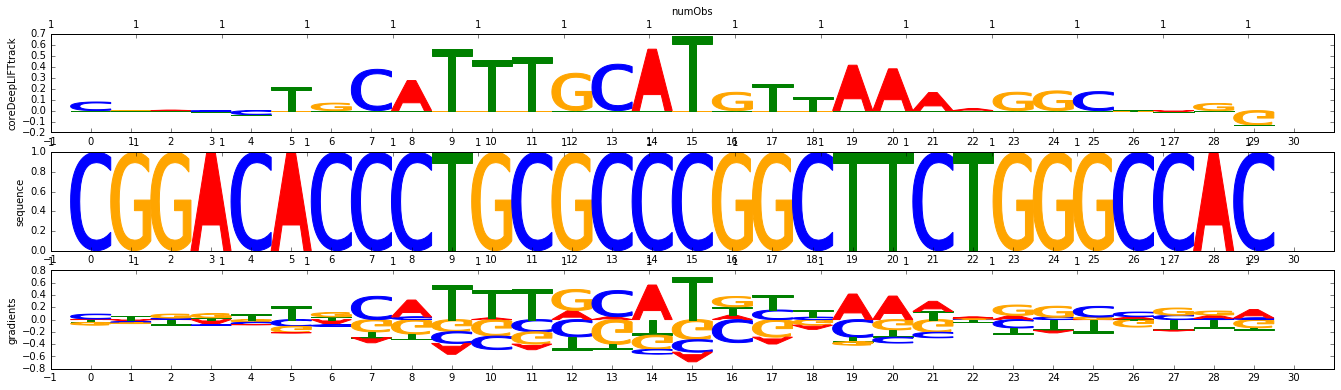

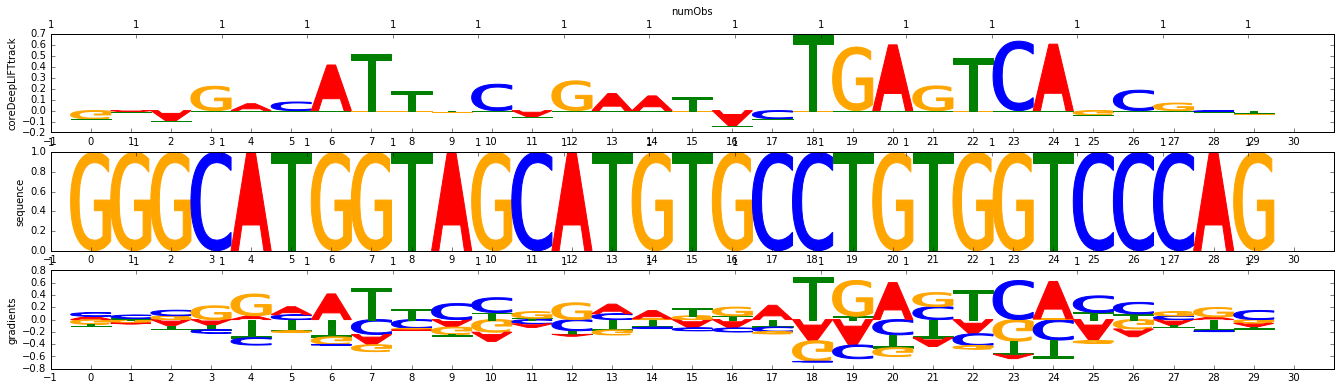

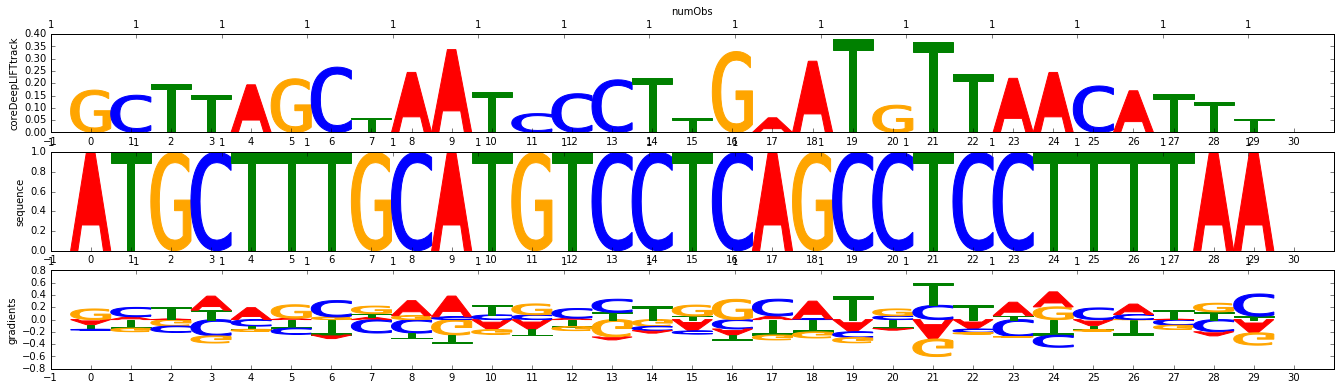

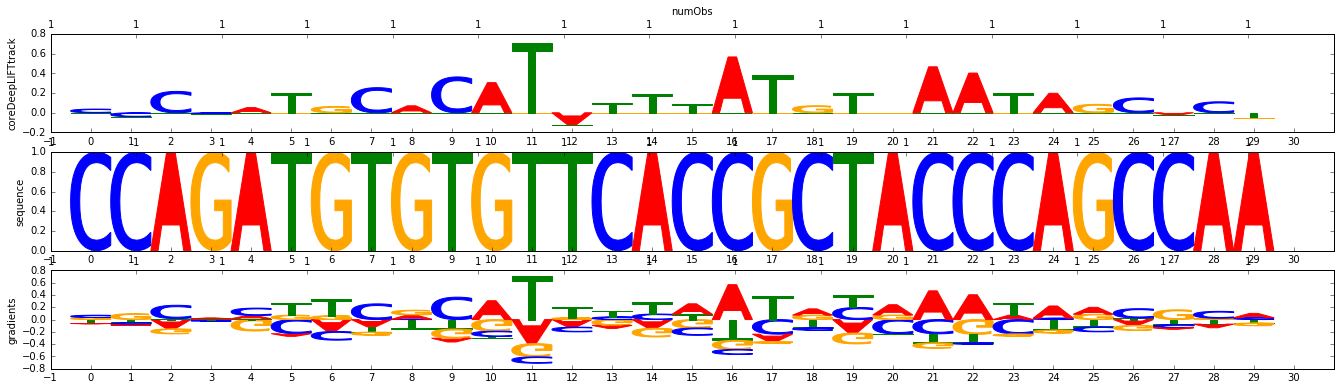

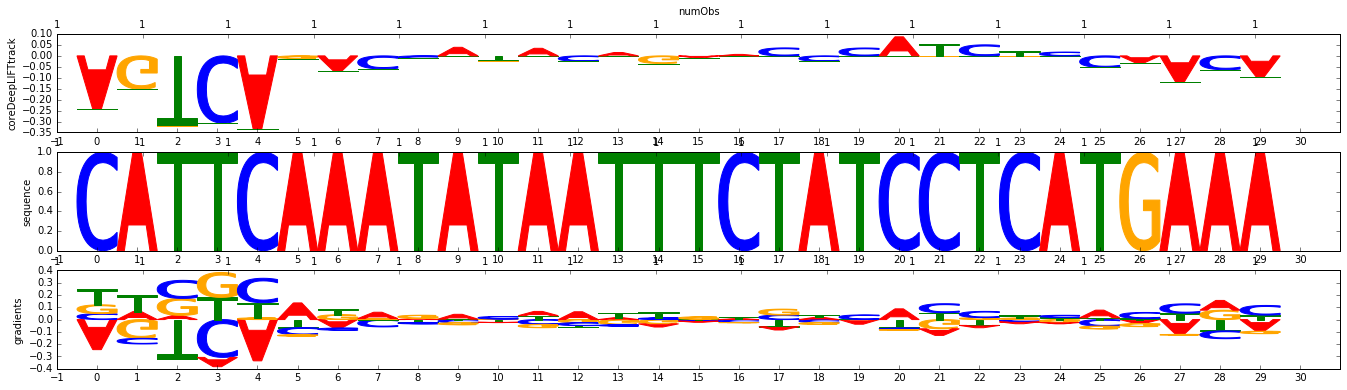

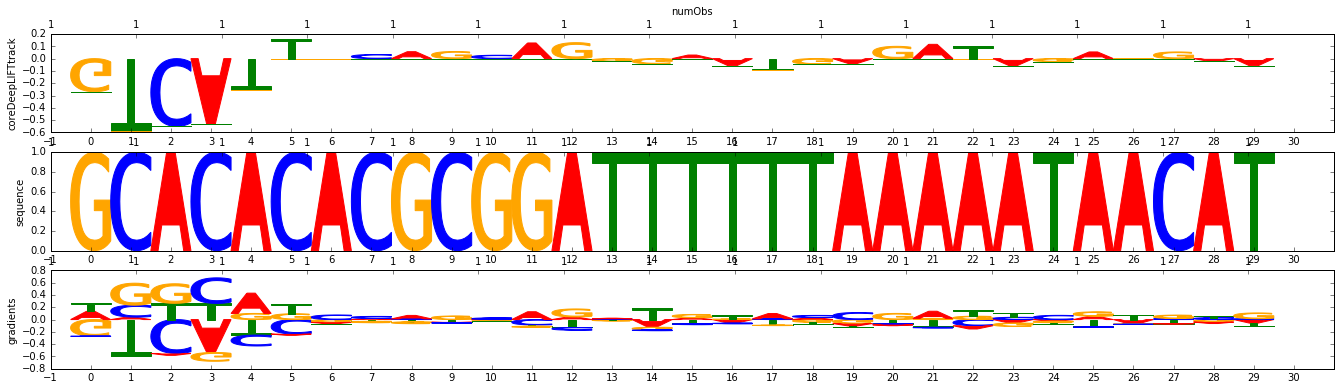

In [15]:
#visually explore the grammars originating from a few examples to get a sense of what they look like
reload(csi)
trackNamesToPrint=[csi.coreDeepLIFTtrackName, "sequence", "gradients"]
for idx in range(5):
    csi.printGrammarWithIdx(grammars, idx=idx, trackNamesToPrint=trackNamesToPrint, heightPerTrack=2);
for idx in range(-5,0):
    csi.printGrammarWithIdx(grammars, idx=idx, trackNamesToPrint=trackNamesToPrint, heightPerTrack=2);
    

In [16]:
#xcor code can currently only handle equally sized seqlets so filter out the few seqlets that were at the
#edge and are thus smaller
normalGrammarLen = np.max([x.summedCoreDeepLIFTtrack.shape[1] for x in grammars])
grammars = [x for x in grammars if x.summedCoreDeepLIFTtrack.shape[1]==normalGrammarLen]

In [17]:
import time;
reload(csi)
reload(util)

#Compute the pairwise distance matrix between the grammars.
#This is by far the most time-consuming operation, so multithread.
#If it takes too long try subsetting to the top 1000 grammars. Remember for
#this step you don't need all the grammars, just a representative
#set for clustering.
#On my mac, for 1000 grammars of len 30bp and 4 threads, this
#took 90 seconds..but it *scales quadratically* so be careful
#grammarsSubset = grammars[:1000]
grammarsSubset=grammars[0:1000]
accountForRevComp=True
#subtracksToInclude represents the set of subtracks to do the
#cross correlation based on. You could in theory do the
#cross correlation based on some of the augmented data tracks
#as well
#subtracksToInclude=[csi.Grammar.coreDeepLIFTtrackName]
subtracksToInclude=["gradients"]
os.environ['CUDA_DEVICE']="7" #you should set this if you plan to do xcor on the GPU
grammarsCorrMat = csi.getCorrelationMatrix(
                        grammarsSubset
                        , subtracksToInclude=subtracksToInclude
                        , accountForRevComp=accountForRevComp
                        , numThreads=25
                        , secondsBetweenUpdates=3
                        , xcorBatchSize=10 #set this to something other than None to do xcor on GPU
                        #, subtrackNormaliseFunc=util.CROSSC_NORMFUNC.perPositionRange
                        )

Num words: 1000
FFT size 128
FFT time: 0.798373937607
EWPMK time: 0.298432588577
ifft time: 0.889940023422
MAI time: 93.0347766876
FFT size 128
FFT time: 0.0166430473328
EWPMK time: 0.304406881332
ifft time: 0.894865512848
MAI time: 94.8734009266
Seconds to compute corr mat: 192.344369173


(1000, 1000)


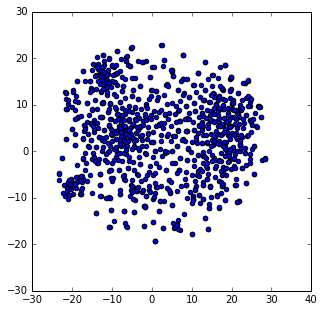

In [18]:
#find the t-sne embedding using the distance metric
reload(csi)
import sklearn
print(grammarsCorrMat.shape)
embedding = csi.getTsneEmbeddingOfGrammars(grammarsCorrMat, perplexity=30)
mplh.scatterPlot(embedding)
#tsne = manifold.TSNE(metric='precomputed', perplexity=30);
#grammarsDistMat = np.max(grammarsCorrMat)-grammarsCorrMat
#embedding = tsne.fit_transform(grammarsDistMat)
#import matplotlib.pyplot as plt
#plt.scatter(embedding[:,0], embedding[:,1])

In [19]:
#spectral clustering
reload(csi)
reload(util)
labels = csi.getSpectralClustering(mat=grammarsCorrMat, n_clusters=10, affinity="precomputed");
labels=csi.colorTSNEembeddingBySpectralClustering(grammarsCorrMat, embedding, n_clusters=4)
outputFile='TSNE_task_'+str(neuronOfInterest_idx)+".png"


No colors supplied, so autogen'd as:
(0, [0.0, 1.0, 0.0])
(1, [1.0, 0.5000000000000001, 0.0])
(2, [1.0, 0.0, 0.49999999999999983])
(3, [0.0, 0.0, 1.0])


In [20]:
reload(deepLIFTutils)
reload(deepLIFTonGPU)
reload(csi)
reload(util)
reload(importData)
import criticalSubsetIdentification
#reload(xcor)

#The trimming function is optional; it is used to further trim uninformative flanks.
#TrimArrayColumnsToPercent trims the grammar to the smallest subsequence that has "percent" importance
#of the original full sequence
#trimmingFunc = csi.TrimArrayColumnsToPercent(percent=0.95)
#TrimArrayColumsnToNumUnderlyingObs resticts attention to those positions in the grammar
#that have at least 20% of the total observations for the grammar supporting them.
trimmingFunc = csi.TrimArrayColumnsToNumUnderlyingObs(0.2)
#once again, subtracksToInclude indicates the subtracks to consider for merging. Should be
#the same as what you supplied for the cross-correlation
mergedGrammars = csi.createMergedGrammars(labels, grammars
                                          , subtracksToInclude=subtracksToInclude
                                          , accountForRevComp=accountForRevComp)
mergedGrammars = csi.adjustGrammarsUsingTrimmingCriterion(mergedGrammars,trimmingFunc=trimmingFunc);

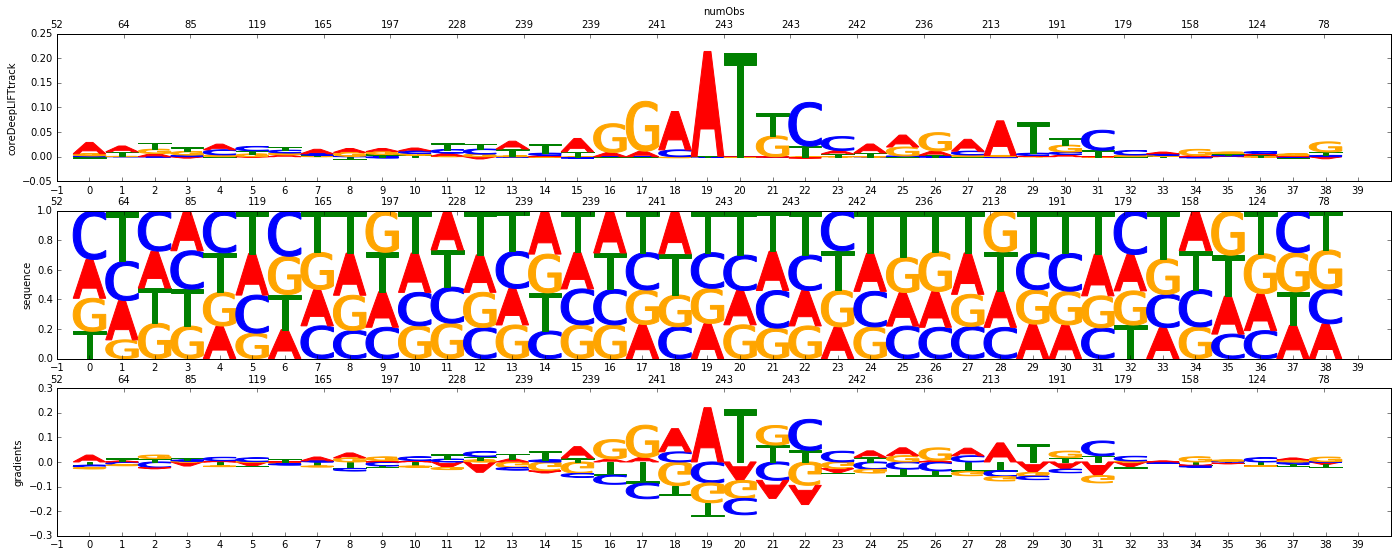

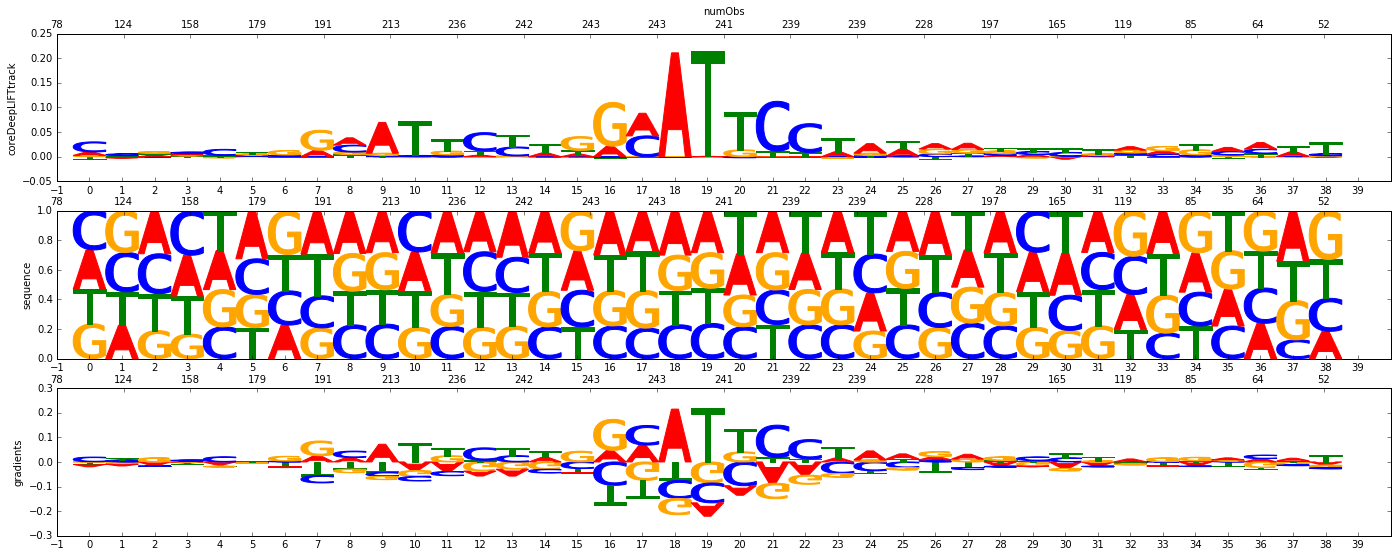

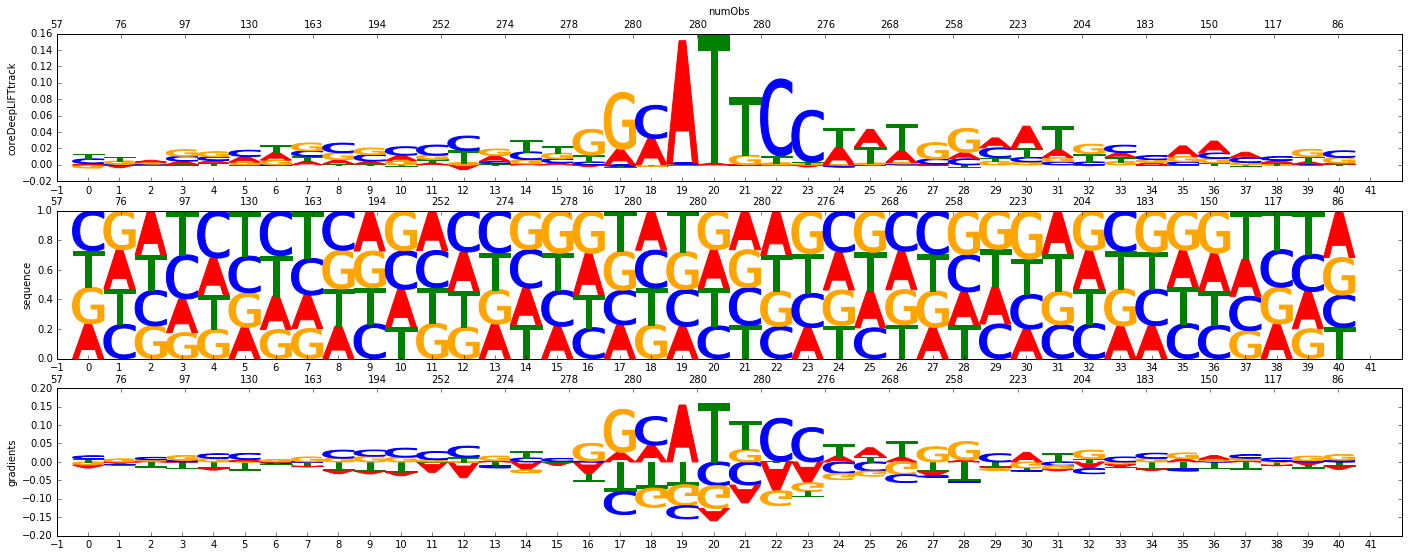

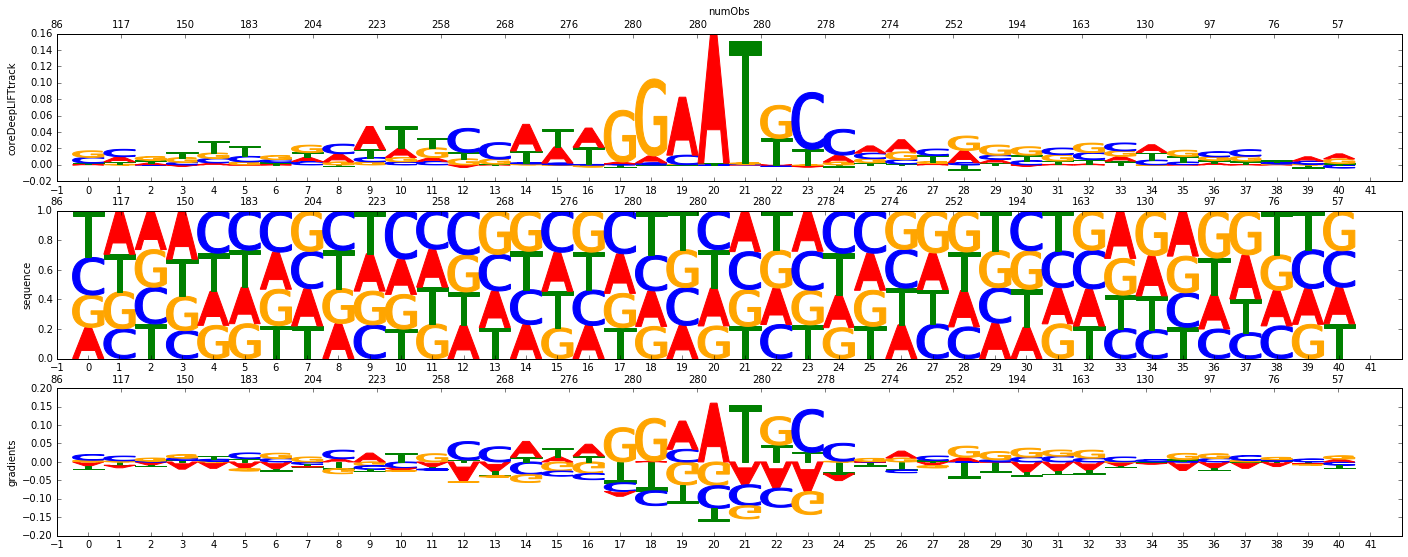

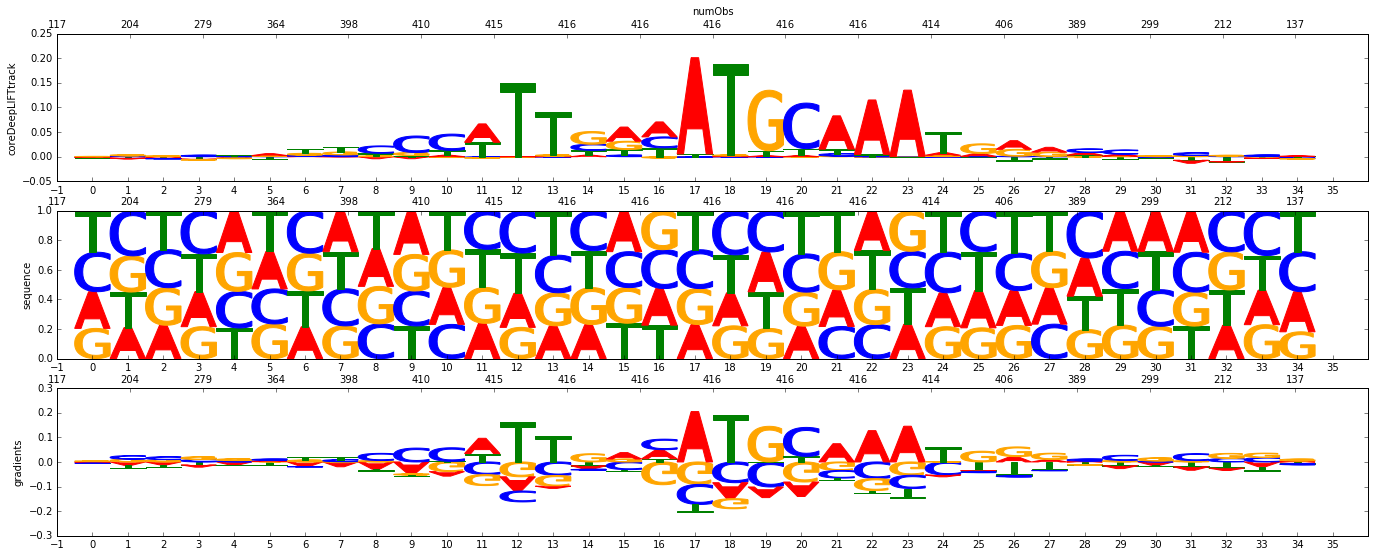

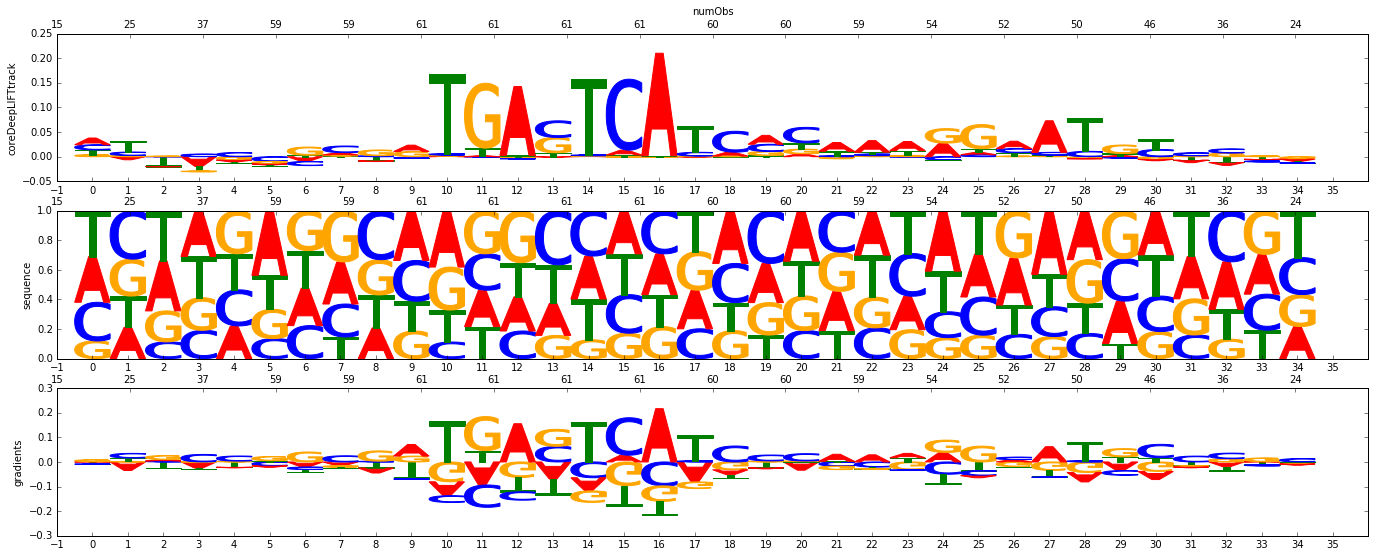

In [21]:
reload(csi)
for grammar in mergedGrammars.values():
    csi.printGrammar(grammar, trackNamesToPrint=[csi.Grammar.coreDeepLIFTtrackName, "sequence", "gradients"])
    csi.printGrammar(grammar.getRevCompGrammar(), trackNamesToPrint=[csi.Grammar.coreDeepLIFTtrackName, "sequence","gradients"])

In [23]:
reload(importData)
#yamlDir="/srv/scratch/annashch/deeplearning/heterokaryon/yaml"
yamlDir="/srv/scratch/annashch/deeplearning/heterokaryon/yaml_sliding_pangwei_allpairs"
trainData, validData, testData = importData.loadTrainTestValidFromYaml(
                                    yamlDir+"/features.yaml"
                                    ,yamlDir+"/labels.yaml"
                                    ,yamlDir+"/splits.yaml")
allData=importData.InputData.concat(trainData, validData, testData)


Processed 5000 lines of inputs/heterokaryon.sliding.pangwei.1.fasta
Processed 10000 lines of inputs/heterokaryon.sliding.pangwei.1.fasta
Processed 15000 lines of inputs/heterokaryon.sliding.pangwei.1.fasta
Processed 20000 lines of inputs/heterokaryon.sliding.pangwei.1.fasta
Processed 25000 lines of inputs/heterokaryon.sliding.pangwei.1.fasta
Processed 30000 lines of inputs/heterokaryon.sliding.pangwei.1.fasta
Processed 35000 lines of inputs/heterokaryon.sliding.pangwei.1.fasta
Processed 40000 lines of inputs/heterokaryon.sliding.pangwei.1.fasta
Processed 45000 lines of inputs/heterokaryon.sliding.pangwei.1.fasta
Processed 50000 lines of inputs/heterokaryon.sliding.pangwei.1.fasta
Processed 55000 lines of inputs/heterokaryon.sliding.pangwei.1.fasta
Processed 60000 lines of inputs/heterokaryon.sliding.pangwei.1.fasta
Processed 65000 lines of inputs/heterokaryon.sliding.pangwei.1.fasta
Processed 70000 lines of inputs/heterokaryon.sliding.pangwei.1.fasta
Processed 75000 lines of inputs/het

In [32]:
reload(deepLIFTutils)
reload(deepLIFTonGPU)
os.environ['CUDA_DEVICE']="7" #you should set this if you plan to do xcor on the GPU
allDLOutputOnAllPositives = deepLIFTutils.runScoreFuncOnData(batchSize=10
                                                          , data=[allData.X]
                                                          , scoreFunc=scoreFunc
                                                          , progressUpdate=1000)

('On', 0)


RuntimeError: cublasSgemm failed (14) an internal operation failed
 unit=0 N=0, c.dims=[10 1000], a.dim=[10 3600], alpha=%f, beta=%f, a=%p, b=%p, c=%p sa_0=%d, sa_1=%d, sb_0=%d, sb_1=%d, sc_0=%d, sc_1=%d
Apply node that caused the error: GpuDot22(GpuReshape{2}.0, <CudaNdarrayType(float32, matrix)>)
Toposort index: 245
Inputs types: [CudaNdarrayType(float32, matrix), CudaNdarrayType(float32, matrix)]
Inputs shapes: [(10, 3600), (3600, 1000)]
Inputs strides: [(3600, 1), (1000, 1)]
Inputs values: ['not shown', 'not shown']
Outputs clients: [[GpuElemwise{add,no_inplace}(GpuDot22.0, GpuDimShuffle{x,0}.0)]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [ ]:
allPositivesDLRawContribs_singleNeuron = allDLOutputOnAllPositives[ScoreTypes.deepLIFT_rawContrib]\
                                                    [0]\
                                                    [trackLayerIdx]\
                                                    [neuronOfInterest_idx];

In [ ]:
allPositivesDLRawContribGrads_singleNeuron = allDLOutputOnAllPositives[ScoreTypes.sensitivity]\
                                                    [0]\
                                                    [trackLayerIdx]\
                                                    [neuronOfInterest_idx];

In [ ]:
reload(csi)
reload(util)
N=3
consolidatedDeepLIFTs = [mergedGrammars[i].normedCoreDeepLIFTtrack for i in mergedGrammars]
consolidatedDeepLIFTPWMs = [np.log(mergedGrammars[i].getNormalisedDataTrack('sequence'))-np.log(0.25)\
                            for i in mergedGrammars]
consolidatedDeepLIFTGradients = [mergedGrammars[i].getNormalisedDataTrack("gradients") for i in mergedGrammars]
#topHits = np.array(csi.getTopNGreedyNonOverlappingCorrScores_onFullSet(
#        largerArrs=np.squeeze(allData.X) #np.squeeze(allPositivesDLRawContribs_singleNeuron)
#        ,smallerArrs=consolidatedDeepLIFTPWMs #consolidatedDeepLIFTs
#        ,revCompFunc=csi.dnaRevCompFunc
#        ,N=N
#        ,excludeHitsWithinWindow=20
#       ,secondsBetweenUpdates=1
#        ,numThreads=25))

#topHits_normalisedByMaxAtEachPos = np.array(csi.getTopNGreedyNonOverlappingCorrScores_onFullSet(
#        largerArrs=np.squeeze(allPositivesDLRawContribs_singleNeuron)
#        ,smallerArrs=consolidatedDeepLIFTs
#        ,revCompFunc=csi.dnaRevCompFunc
#        ,N=N
#        ,excludeHitsWithinWindow=20
#        ,secondsBetweenUpdates=1
#        ,numThreads=25
#        ,normaliseByMaxAtEachPos=True
#        ))

topHits_masterFilter = np.array(csi.getTopNGreedyNonOverlappingCorrScores_onFullSet(
        largerArrs=np.squeeze(allData.X)#np.squeeze(allPositivesDLRawContribGrads_singleNeuron)#
        ,smallerArrs=consolidatedDeepLIFTGradients
        ,revCompFunc=csi.dnaRevCompFunc
        ,N=N
        ,excludeHitsWithinWindow=20
        ,secondsBetweenUpdates=1
        ,numThreads=25
        ,normaliseByMaxAtEachPos=True
        ))
topHits=topHits_masterFilter

In [ ]:
reload(csi)
allPosHits_2Dscores, allPosHits_ids = csi.obtain2DscoresForAllLabelsSatisfying(
                        motifHitsSets = [topHits]
                        , datas = [allData]
                        , labelCriterion=lambda x: x[0]==1
                        , twoDscoreGetterFunc=csi.ReshapeCorrScoresInto2Dmatrix_normalisePerMotif(topNtoKeep=1))
print(len(allPosHits_2Dscores))

In [ ]:
from sklearn import manifold
embedding = manifold.TSNE(metric='euclidean', perplexity=100, verbose=2).fit_transform(allPosHits_2Dscores)
mplh.scatterPlot(embedding)

In [ ]:
print(topHits.shape)


In [ ]:
reload(mplh)
from sklearn import mixture
gmmLabels = mixture.GMM(n_components=3, covariance_type='diag',verbose=0, n_iter=50).fit_predict(allPosHits_2Dscores)

In [ ]:
labels=gmmLabels
mplh.plotHeatmapSortedByLabels(allPosHits_2Dscores, labels=labels, zeroCenter=True, figsize=(7,7))
mplh.scatterPlot(embedding, labels=labels, figsize=(7,7))

In [ ]:
reload(csi)
reload(util)
reload(fp)
#Every set of labels provided in the list to labelSetsToFilterFor will generate its own
#BED file with the name GMM_5clust_labels-[cluster numbers separated by dashes].txt
#It will also generate GMM_5clust_all.txt which contains all the regions and can be used
#as the background
os.system("rm GoodGMM*")
util.printCoordinatesForLabelSubsets(regionIds=allPosHits_ids
                                    ,labels=labels
                                    ,labelSetsToFilterFor=\
                                    [[0],[1],[2],[1,2]]
                                    ,outputFilePrefix="GoodGMM_3clust")

In [ ]:
reload(csi)
N=1; zScoreThresholdForHit={0:-1,1:-1,2:-1,3:-1};
#Let's attempt to extract grammars
topHitsForEachRow = np.array(csi.getTopNGreedyNonOverlappingCorrScores_onFullSet(
        largerArrs=np.squeeze(allData.X)#np.squeeze(allPositivesDLRawContribs_singleNeuron)#
        #Looks like there's a pattern involving Zic and the Nanog homeobox (motifs 0 and 2) so use only them
        #,smallerArrs=[consolidatedDeepLIFTs[i]-np.mean(consolidatedDeepLIFTs[i],axis=0)[None,:]
        #              for i in [0,2]] #[consolidatedDeepLIFTPWMs[i] for i in [0,2]] #
        ,smallerArrs=[consolidatedDeepLIFTGradients[i]
                      for i in [0,1]] #[consolidatedDeepLIFTPWMs[i] for i in [0,2]] #
        ,revCompFunc=csi.dnaRevCompFunc
        ,N=N
        ,excludeHitsWithinWindow=10
        ,secondsBetweenUpdates=1
        ,numThreads=25
        ,normaliseByMaxAtEachPos=True))

In [ ]:
reload(mplh)
reload(csi)
reload(deepLIFTutils)
hitsForRows = csi.obtainHitsForRows(topHitsForEachRow, zScoreThresholdForHit)
pairwiseDistances = csi.obtainPairwiseDistancesBetweenHits(hitsForRows)
csi.plotPairwiseDistances(pairwiseDistances, oneHotSequenceData=allPositivesDLRawContribs_singleNeuron, topNtoListOut=5)

In [ ]:
#motif density analysis
reload(csi)
N=30; zScoreThresholdForHit={0:3,1:3,2:3};
#Let's attempt to extract grammars
topHitsForEachRow = np.array(csi.getTopNGreedyNonOverlappingCorrScores_onFullSet(
        largerArrs=np.squeeze(allPositivesDLRawContribs_singleNeuron)#np.squeeze(allData.X)#
        #Looks like there's a pattern involving Zic and the Nanog homeobox (motifs 0 and 2) so use only them
        ,smallerArrs=[consolidatedDeepLIFTs[i] for i in [1]] #[consolidatedDeepLIFTPWMs[i] for i in [0,2]] #
        ,revCompFunc=csi.dnaRevCompFunc
        ,N=N
        ,excludeHitsWithinWindow=10
        ,secondsBetweenUpdates=1
        ,numThreads=25
        ,normaliseByMaxAtEachPos=True))

In [ ]:
mplh.plotHist(np.ravel(topHitsForEachRow[:,0,0,:]), bins=50)


In [ ]:
reload(mplh)
reload(csi)
reload(deepLIFTutils)
hitsForRows = csi.obtainHitsForRows(topHitsForEachRow, zScoreThresholdForHit)

In [ ]:
len(hitsForRows)


In [ ]:
mplh.plotHist([len(x) for x in hitsForRows],bins=10)


In [ ]:
hitsForRowsSorted = sorted(enumerate(hitsForRows), key=lambda x: -len(x[1]))
hitsForRowsSorted[:3]

In [ ]:
reload(deepLIFTutils)
for i in range(10):
    idx=hitsForRowsSorted[i][0]
    minIdx = min(x.pos for x in hitsForRowsSorted[i][1])
    maxIdx = max(x.pos for x in hitsForRowsSorted[i][1])+40
    deepLIFTutils.makePngOfSequenceDeepLIFTScores(allPositivesDLRawContribs_singleNeuron[idx][:,:,minIdx:maxIdx][:,::-1,::-1], pngName=None)